In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import gzip
sys.path.insert(0, '../src/')
import helpers as h
%matplotlib inline

In [2]:
n_samples = 100
n_samples_fold = (n_samples+1)//2
mac = np.arange(1, n_samples_fold+1)

# msprime

## Import data

In [3]:
def get_data(file_list, r_list, n_samples):
    data = h.import_msprime_corr(file_list, n_samples)
    pi, sfs, jsfs, pi_corr, lolo_corr, lohi_corr, hihi_corr = data
    return r_list, sfs/pi[:,None], pi, pi_corr, lohi_corr

In [4]:
# Recombination rates
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
# Beta coalescent alpha parameter
a_list = [2.0, 1.75, 1.5, 1.25]
# Exp growth parameter
g_list = [1.0, 2.0, 4.0, 8.0]
# Piecewise-constant growth time and factor
t_list = [0.01, 0.1, 1.0]
s_list = [0.2, 0.1, 0.05, 0.01]
# Migration
m_list1 = np.logspace(-1,1,5)[2:]
m_list2 = np.logspace(-1,1,5)[:2]

In [5]:
head = '../simulations/msprime/jsfs_n-{}_'.format(n_samples)

In [6]:
a_kingman = 2.0
a_beta = 1.5
g = 4.0

In [7]:
r_list_kingman = r_list[:-3]
r_list_beta = r_list[:-3]
r_list_exp = r_list[:-3]

file_list_kingman = [head + 'a-{}_r-{}.txt'.format(a_kingman, r) for r in r_list_kingman]
file_list_beta = [head + 'a-{}_r-{}.txt'.format(a_beta, r) for r in r_list_beta]
file_list_exp = [head + 'g-{}_r-{}.txt'.format(g, r) for r in r_list_exp]

data_kingman = h.import_msprime_corr(file_list_kingman, n_samples)
data_beta = h.import_msprime_corr(file_list_beta, n_samples)
data_exp = h.import_msprime_corr(file_list_exp, n_samples)

In [8]:
print(r_list_kingman * data_kingman[0]/2)
print(r_list_beta * data_beta[0]/2)
print(r_list_exp * data_exp[0]/2)

[  0.00000000e+00   9.99882981e-02   2.15176804e-01   4.64798780e-01
   1.00106326e+00   2.15625131e+00   4.64379505e+00   1.00079303e+01
   2.15330978e+01   4.64791850e+01   1.00126161e+02]
[  0.00000000e+00   9.99212718e-02   2.15752373e-01   4.63928942e-01
   1.00414203e+00   2.14957938e+00   4.63621031e+00   9.99076503e+00
   2.15642660e+01   4.63250219e+01   1.00500728e+02]
[  0.00000000e+00   3.35027186e-02   7.21949278e-02   1.55534240e-01
   3.35067718e-01   7.22407256e-01   1.55505434e+00   3.35196341e+00
   7.22143293e+00   1.55482834e+01   3.35443394e+01]


In [9]:
def wpmi(pi, sfs, sfs2):
    return (sfs2/pi**2) * np.log2(sfs2 / np.outer(sfs, sfs))

In [10]:
chroms = ['Chr'+x for x in ['2L','2R','3L','3R']]
file_list_fastNeutrino = ['../simulations/msprime/jsfs_fastNeutrino_n-{}_{}_3EpochConstConst_r-{}.txt'.format(n_samples, ch, r)
                          for ch in chroms for r in r_list]
data_fastNeutrino = get_data(file_list_fastNeutrino, r_list, n_samples)

In [11]:
r_list_beta = r_list[:-3]
file_list_beta = [head + 'a-{}_r-{}.txt'.format(a, r) for a in a_list for r in r_list_beta]
data_beta = get_data(file_list_beta, r_list_beta, n_samples)

r_list_kingman = r_list_beta
lrb = len(r_list_beta)

sfs_kingman = data_beta[1][:lrb]
pi_kingman = data_beta[2][:lrb]
pic_kingman = data_beta[3][:lrb]
lhc_kingman = data_beta[4][:lrb]

d_kingman = r_list_kingman*pi_kingman/2

In [12]:
r_list_exp = r_list[:-3]
file_list_exp = [head + 'g-{}_r-{}.txt'.format(g, r) for g in g_list for r in r_list_exp]
data_exp = get_data(file_list_exp, r_list_exp, n_samples)

In [13]:
r_list_pwc = r_list
data_pwc = []
for i_t, t in enumerate(t_list):
    fl = [head + 'T-{}_S-{}_r-{}.txt'.format(t,s,r) for s in s_list for r in r_list_pwc]
    data = get_data(fl, r_list_pwc, n_samples)
    data_pwc.append(data)

In [14]:
r_list_mig1 = r_list[:-2]
file_list_mig1 = [head + 'd-2_M-{}_r-{}.txt'.format(m, r) for m in m_list1 for r in r_list_mig1]
data_mig1 = get_data(file_list_mig1, r_list_mig1, n_samples)

In [15]:
r_list_mig2 = r_list[:-2]/10
file_list_mig2 = [head + 'd-2_M-{}_r-{}.txt'.format(m, r) for m in m_list2 for r in r_list_mig2]
data_mig2 = get_data(file_list_mig2, r_list_mig2, n_samples)

## Make plots

In [16]:
def tajimasD(n, eta):
    theta_pi = h.sfs2pi(eta, n)
    theta_w  = np.sum(eta) / np.sum(1/np.arange(1,n))
    return theta_pi - theta_w

In [17]:
def plot_row(axes, r_list, sfs, pi, pic, lhc, cutoffs, n_samples=100, x_lohi='d'):
    '''
    Take a set of axes and plot the various data on them
    '''
    # The axis limits
    d_lim = [8e-2, (1/8)*1e3]
    pic_lim = [-0.01, 0.31]
    lhc_lim = [-0.11,0.11]
    #lhc_lim = [-0.021,0.021]
    sfs_lim = [2e-3, 2e1]

    step = len(r_list)
    n_steps = sfs.shape[0]//step
    
    for i in range(n_steps):
        tajD = tajimasD(n_samples, np.mean(sfs[i*step:(i+1)*step],axis=0))
        color = plt.get_cmap('viridis')(-tajD)
        
        d = r_list*pi[i*step:(i+1)*step]/2

        y1 = pic[i*step:(i+1)*step]
        
        # Plot LoHi-Correlations for different cutoffs
        for j, cutoff in enumerate(cutoffs):
            ax = axes[j]
            y = lhc[i*step:(i+1)*step, cutoff-1]
            if x_lohi == 'd':
                x = d
                ax.semilogx(x,y, color=color)
                ax.semilogx(d_kingman, lhc_kingman[:,cutoff-1], ':', color='k')
                ax.hlines(0, d_lim[0], d_lim[1], linestyle='dashed', color='.5')
                ax.set_xlim(d_lim)
            elif x_lohi == 'pic':
                x = y1
                ax.plot(x,y, color=color)
                ax.plot(pic_kingman, lhc_kingman[:,cutoff-1], ':', color='0.5')
                ax.hlines(0, pic_lim[0], pic_lim[1])
                ax.set_xlim(pic_lim)
            ax.set_ylim(lhc_lim)
            
            ax.set_yticks([-0.1,0,0.1])
            if j > 0:
                ax.set_yticklabels([])
    return axes

In [27]:
def plot_row_slim(axes, d, sfs, pic, lhc, cutoffs, n_samples=100, x_lohi='d'):
    '''
    Take a set of axes and plot the various data on them
    '''
    # The axis limits
    d_lim = [8e-2, (1/8)*1e3]
    pic_lim = [-0.01, 0.31]
    lhc_lim = [-0.11,0.11]

    sfs_lim = [2e-3, 2e1]
    
    tajD = tajimasD(n_samples, sfs)
    color = plt.get_cmap('viridis')(tajD)

    # Plot Pi-correlation
    x1 = d
    y1 = pic

    # Plot LoHi-Correlations for different cutoffs
    for j, cutoff in enumerate(cutoffs):
        ax = axes[j]
        y = h.smooth(lhc[cutoff-1], 101)
        if x_lohi == 'd':
            x = d
            ax.semilogx(x,y, color=color)
            ax.semilogx(d_kingman, lhc_kingman[:,cutoff-1], ':', color='k')
            ax.hlines(0, d_lim[0], d_lim[1], linestyle='dashed', color='.5')
            ax.set_xlim(d_lim)
        elif x_lohi == 'pic':
            x = y1
            # Don't use the d=0 bin
            ax.plot(x[1:],y[1:], color=color)
            ax.plot(pic_kingman, lhc_kingman[:,cutoff-1], ':', color='0.5')
            ax.hlines(0, pic_lim[0], pic_lim[1])
            ax.set_xlim(pic_lim)
        ax.set_ylim(lhc_lim)
        
        ax.set_yticks([-0.1,0,0.1])
        if j > 0:
            ax.set_yticklabels([])
    
    return axes


In [25]:
single_col_width = 3.5
# mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] ='serif'

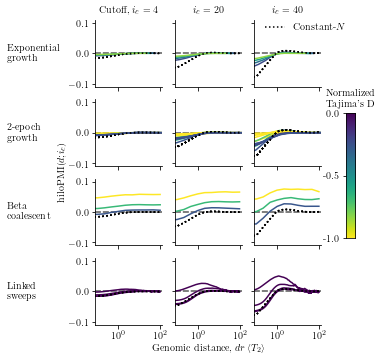

In [71]:
cutoffs = [4, 20, 40]
n_rows = 4
n_cols = len(cutoffs)
x_lohi = 'd'

xscale = 1.5
yscale = 1.5
fig = plt.figure(figsize=(xscale*single_col_width, yscale*single_col_width))

x_text = 0.025 / xscale
x_panel = 0.25
x_cb = 0.9
panel_size = 0.265
panel_buffer = 0.05
panel_bottom = 0.1
panel_width = panel_size / xscale
panel_height = panel_size / yscale
panel_xbuffer = panel_buffer / xscale
panel_ybuffer = panel_buffer / yscale    

# EXP
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                      panel_bottom + 3*(panel_height+panel_ybuffer),
                      panel_width,
                      panel_height]) for i in range(n_cols)]
axes[0].set_title('Cutoff, $i_c = 4$')
axes[1].set_title('$i_c = 20$')
axes[2].set_title('$i_c = 40$')

axes = plot_row(axes, *data_exp, cutoffs, x_lohi=x_lohi)
axes[-1].lines[-1].set_label('Constant-$N$')
axes[-1].legend(frameon=False, loc=(0.1,0.75))

# PWC
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                  panel_bottom + 2*(panel_height+panel_ybuffer),
                  panel_width,
                  panel_height]) for i in range(n_cols)]
    #axes = [fig.add_subplot(n_rows, n_cols, n_cols+i+1) for i in range(n_cols)]
for i_t, t in enumerate(t_list):
    axes = plot_row(axes, *data_pwc[i_t], cutoffs, x_lohi=x_lohi)

# BETA
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                  panel_bottom + 1*(panel_height+panel_ybuffer),
                  panel_width,
                  panel_height]) for i in range(n_cols)]
axes = plot_row(axes, *data_beta, cutoffs, x_lohi=x_lohi)
# Remove the redundant Kingman line
for ax in axes:
    ax.lines.pop(0)

for ax in fig.get_axes():
    ax.set_xticklabels([])
    
# Sweeps
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                  panel_bottom,
                  panel_width,
                  panel_height]) for i in range(n_cols)]
for fsel in fsels_sweeps:
    data = get_data_slim(fn_pattern.format('sweeps', fsel))
    axes = plot_row_slim(axes, *data, cutoffs, x_lohi=x_lohi)
axes[1].set_xlabel(r'Genomic distance, $d r \left< T_2 \right>$')
    
for ax in fig.get_axes():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax = fig.add_axes([x_cb,0.33,0.05,0.33])
v = 1
norm = mpl.colors.Normalize(vmin=-v, vmax=v)
gradient = np.linspace(-v, v, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient.T, aspect=0.1, norm=norm, cmap=plt.get_cmap('viridis_r'))
ax.set_xticks([])
ax.set_yticks([0,256//2,256])
ax.set_yticklabels([-1.0, -0.5, 0.0])
ax.set_ylim([0,256])
ax.set_title("Normalized\nTajima's D")


fig.text(x_text, panel_bottom + panel_height/2 + 3*(panel_height+panel_ybuffer), "Exponential\ngrowth", va='center')
fig.text(x_text, panel_bottom + panel_height/2 + 2*(panel_height+panel_ybuffer), "2-epoch\ngrowth", va='center')
fig.text(x_text, panel_bottom + panel_height/2 + (panel_height+panel_ybuffer), "Beta\ncoalescent", va='center')
fig.text(x_text, panel_bottom + panel_height/2, "Linked\nsweeps", va='center')

fig.text(0.15, panel_bottom + 2*panel_height + 1.5*panel_ybuffer, r"hiloPMI$(d;i_c)$", rotation=90, va="center")
fig.savefig('../manuscript/figures/hilopmi_vs_distance.pdf')


# SLiM

## Import data

In [20]:
r_slim = 1e-8
mu = 1e-7
N = 1e3
L = int(1e8)
w = int(1e3)
lim = L//(10*w)
dist = w*np.arange(lim + 1)
fsels_sweeps = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3])[:-1]
fsels_bgsel = np.logspace(-2,0,3)

In [21]:
fn_pattern = '../simulations/slim/{}_fsel-{}_corrmerged.txt.gz'

In [22]:
def get_data_slim(fn):
    data = h.readcorr_normed(fn, n_samples)
    pi, sfs, pic, _, lhc, _ = data
    sfs /= pi
    d = dist*r_slim*pi / (2*mu)
    return d, sfs, pic, lhc

In [24]:
fn = fn_pattern.format('sweeps', '0.0')
data_neut = get_data_slim(fn)

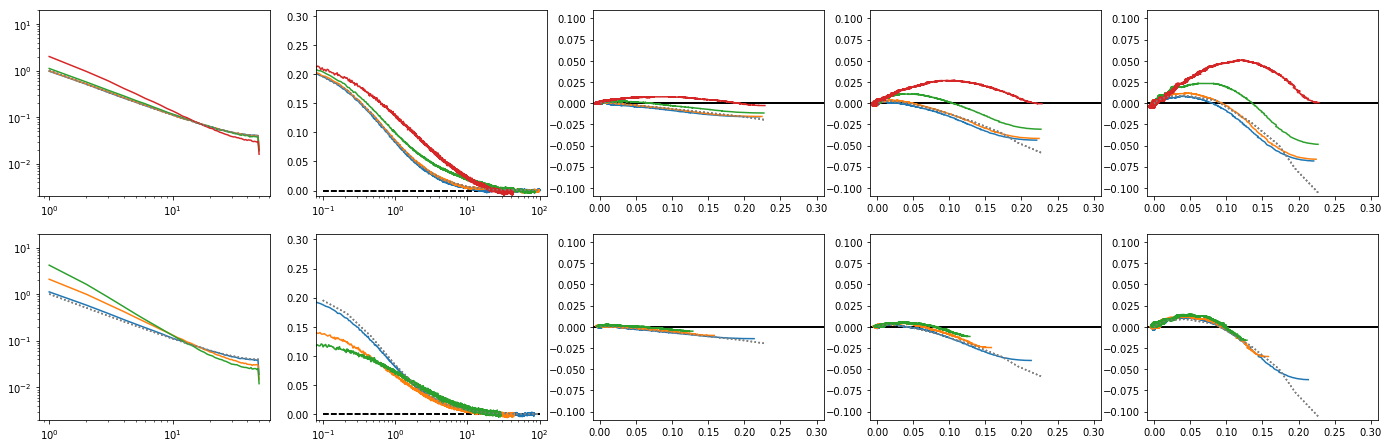

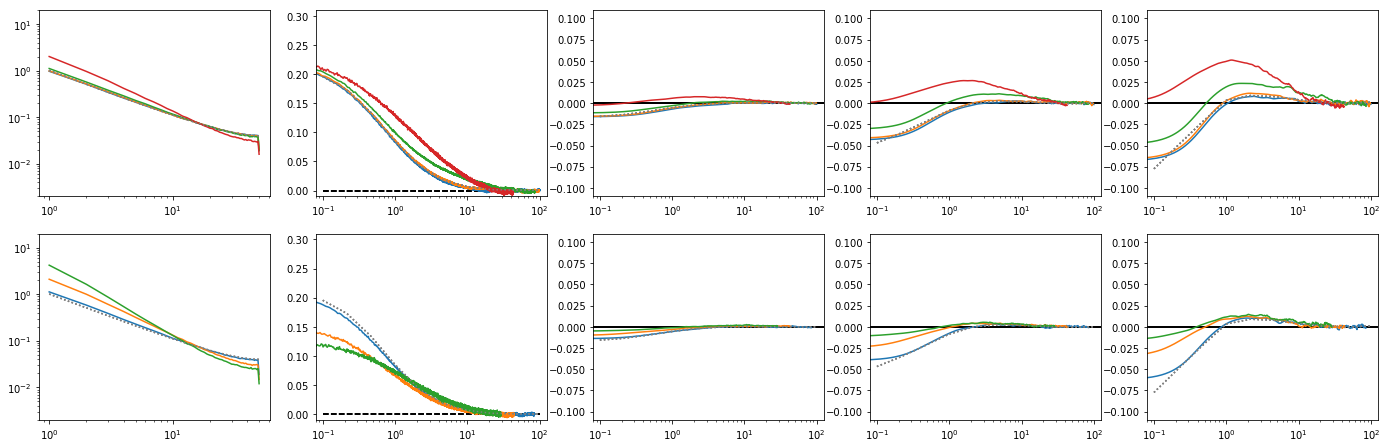

In [132]:
cutoffs = [4, 20, 40]
n_rows = 6
n_cols = 2 + len(cutoffs)

for x_lohi in ['pic', 'd']:
    fig = plt.figure(figsize=(24,24))

    axes = [fig.add_subplot(n_rows, n_cols, i+1) for i in range(n_cols)]
    for fsel in fsels_sweeps:
        data = get_data_slim(fn_pattern.format('sweeps', fsel))
        axes = plot_row_slim(axes, *data, cutoffs, x_lohi=x_lohi)
        axes = [fig.add_subplot(n_rows, n_cols, i+1) for i in range(n_cols)]
        
    axes = [fig.add_subplot(n_rows, n_cols, n_cols + i+1) for i in range(n_cols)]
    for fsel in fsels_bgsel:
        data = get_data_slim(fn_pattern.format('bgsel', fsel))
        axes = plot_row_slim(axes, *data, cutoffs, x_lohi=x_lohi)
    plt.savefig('selection_{}.pdf'.format(x_lohi))